# WeRateDogs Tweet Data Wrangling: Project 2


## Introduction

WeRateDogs is a Twitter page that posts dogs and their description and asks followers to rate the dogs the favor. 

In [1]:
# importing requests to allows me to send HTTP requests using Python
import requests
# importing panda enables me to create and manipulate dataframes.
import pandas as pd
# json helps me to convert JSON files into in-memory Python objects
import json
# Tweepy is used to access the Twitter API
import tweepy
from timeit import default_timer as timer
from PIL import Image
from io import BytesIO
import configparser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data Gathering

1. First, I will import the twitter-archive-enhanced-2.csv file and have a glance on the data.

In [2]:
# reading in the twitter-archive-enhanced-2 file
archive = pd.read_csv('twitter-archive-enhanced-2.csv')
# The first five rows
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [83]:
archive.shape

(2356, 17)

The file, twitter-archieve-enhanced-2.csv, has 17 columns and 2,356 rows. The column headers are descriptive such as retweeted_status_id and retweeted_status_timestamp columns.

2. Then image-predictions.3.tsv is uploaded so as to have sneek peak on the data in the tsv file. 

In [4]:
predictions = pd.read_csv('image-predictions-3.tsv', sep = ('\t'))

In [5]:
# The first five rows
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
# To check the rows and columns
predictions.shape

(2075, 12)

3. Now getting the extra data from Twitter

In [7]:
consumer_key = ('DMDzvnGvVyh12KN4YR40gRMdH')
consumer_secret = ('i62iXnpqOL84qZZjKGcUORy3pNCKOzls3TsQTUU8BJNK6ktyOU')
access_token = ('1541495476448526339-iWFDDhvg8bDey9oj6Bnq8pnp2gYyrZ')
access_token_secret = ('qN7337EldYSUpKqidT13jlfyxFogxkzgF29SLyPNf8TQs')

In [8]:
# The customer_key, customer_secret, access_token, access_token_secrets have been hiddent
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit = True)

In [9]:
## Scarping the data from Twitter
tweet_ids =  archive.tweet_id.values
len(tweet_ids)
tweet_id = archive['tweet_id']
count = 0
retweet_favorite_count = []
fails_dict = {}
start = timer()

with open('tweet_json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            print('Success')
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.errors.TweepyException as e:
            print('Fall')
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fall
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

In [84]:
# Creating the tweet_df dataframe
tweet_df = pd.DataFrame(columns = ['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet_json.txt') as f:
    for line in f:
        status = json.loads(line)
        tweet_id = status["id_str"]
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        tweet_df = tweet_df.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]], 
                                               columns = ['tweet_id', 'retweet_count', 'favorite_count']))
# Checking if the dataframe was formed
tweet_df.tail()

,tweet_id,retweet_count,favorite_count
0,666049248165822465,37,89
0,666044226329800704,115,247
0,666033412701032449,36,100
0,666029285002620928,39,112
0,666020888022790149,422,2293


In [85]:
# Checking for the number of rows and columns
tweet_df.shape

(2326, 3)

## Data Assessing

### Visual assessment

In [11]:
# Assessing using the sample function
archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1233,712809025985978368,NaN,NaN,2016-03-24 01:11:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stubert. He just arrived. 10/10 https:...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/712809025...,10,10,Stubert,None,None,None,None
1106,734787690684657664,NaN,NaN,2016-05-23 16:46:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog is more successful than I will ever b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/734787690...,13,10,None,None,None,None,None
1430,697575480820686848,NaN,NaN,2016-02-11 00:18:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ole. He's not sure how to gravity. 8/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697575480...,8,10,Ole,None,None,None,None
2266,667530908589760512,NaN,NaN,2015-11-20 02:32:25 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet Naphaniel. He doesn't necessarily enjoy h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667530908...,10,10,Naphaniel,None,None,None,None
2077,670833812859932673,NaN,NaN,2015-11-29 05:16:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jett. He is unimpressed by flower. 7/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670833812...,7,10,Jett,None,None,None,None


In [12]:
# Using sample to evaluate the predictions dataframe
predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1024,710588934686908417,https://pbs.twimg.com/media/CdyE2x1W8AAe0TG.jpg,4,Pembroke,0.982004,True,Cardigan,0.008943,True,malamute,0.007550,True
1239,746872823977771008,https://pbs.twimg.com/media/Cl1s1p7WMAA44Vk.jpg,1,Pembroke,0.540201,True,beagle,0.207835,True,Italian_greyhound,0.043565,True
726,686358356425093120,https://pbs.twimg.com/media/CYZvRttWYAE_RXc.jpg,1,pug,0.985237,True,bull_mastiff,0.008841,True,boxer,0.002321,True
112,667911425562669056,https://pbs.twimg.com/media/CUTl5m1WUAAabZG.jpg,1,frilled_lizard,0.257695,False,ox,0.235160,False,triceratops,0.085317,False
24,666353288456101888,https://pbs.twimg.com/media/CT9cx0tUEAAhNN_.jpg,1,malamute,0.336874,True,Siberian_husky,0.147655,True,Eskimo_dog,0.093412,True


In [13]:
# Using the sample to evaluate the tweet_df dataframe
tweet_df.sample(5)

,tweet_id,retweet_count,favorite_count
0,816336735214911488,1802,8166
0,676617503762681856,855,2614
0,667773195014021121,44,204
0,737445876994609152,4063,9457
0,708119489313951744,898,2486


### Programmatic assessment

#### 1. Twitter Archive

In [14]:
# Checking the dataframe's data types and column names
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
# checking if there is any nulls in the tweet_id column
sum(archive.tweet_id.isnull())

0

In [16]:
#Checking if there are duplicated urls
sum(archive.expanded_urls.duplicated())

137

In [17]:
# Checking the number of unique values in the url column
archive.expanded_urls.nunique()

2218

In [18]:
# Checking if there are rating numerators more than 10
archive[archive.rating_numerator > 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2307,666826780179869698,NaN,NaN,2015-11-18 03:54:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 simply brilliant pup https://t.co/V6ZzG4...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666826780...,12,10,None,None,None,None,None
2324,666421158376562688,NaN,NaN,2015-11-17 01:02:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",*internally screaming* 12/10 https://t.co/YMcr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666421158...,12,10,None,None,None,None,None
2329,666373753744588802,NaN,NaN,2015-11-16 21:54:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Those are sunglasses and a jean jacket. 11/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666373753...,11,10,None,None,None,None,None
2336,666273097616637952,NaN,NaN,2015-11-16 15:14:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Can take selfies 11/10 https://t.co/ws2AMaNwPW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666273097...,11,10,None,None,None,None,None


In [19]:
# Checking if there are any values in the rating_denominator above 20
archive[archive.rating_denominator > 20]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845...,60,50,a,None,None,None,None
1433,697463031882764288,NaN,NaN,2016-02-10 16:51:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Wednesday here's a bucket of pups. 44/40...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697463031...,44,40,None,None,None,None,None
1634,684225744407494656,6.842229e+17,4.196984e+09,2016-01-05 04:11:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Two sneaky puppers were not initially seen, mo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684225744...,143,130,None,None,None,None,None


In [20]:
# Checking the number of names in the name column which are unique
archive.name.nunique()

957

In [21]:
# Checking if the name column has duplicated values
sum(archive.name.duplicated())

1399

In [22]:
# Checking the count of the name values
archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [23]:
# Checking if there is a name column that has only a
archive[archive.name == "a"]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747885874...,8,10,a,None,None,None,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None
1017,746872823977771008,NaN,NaN,2016-06-26 01:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a carrot. We only rate dogs. Please on...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746872823...,11,10,a,None,None,None,None
1049,743222593470234624,NaN,NaN,2016-06-15 23:24:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a very rare Great Alaskan Bush Pupper....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743222593...,12,10,a,None,None,pupper,None
1193,717537687239008257,NaN,NaN,2016-04-06 02:21:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",People please. This is a Deadly Mediterranean ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717537687...,11,10,a,None,None,None,None
1207,715733265223708672,NaN,NaN,2016-04-01 02:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a taco. We only rate dogs. Please only...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715733265...,10,10,a,None,None,None,None
1340,704859558691414016,NaN,NaN,2016-03-02 02:43:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a heartbreaking scene of an incredible...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704859558...,10,10,a,None,None,pupper,None


In [24]:
# Checking if the names are capitalized or not
archive.name.str.islower().sum()

109

#### 2. Dogs Prediction

In [25]:
# checking the column names and datatypes
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
# Checking if there are any duplicates in the predictions dataframe
predictions.duplicated().sum()

0

In [27]:
# Checking if there are any duplicates in the predictions jpg_url column
predictions.jpg_url.duplicated().sum()

66

In [28]:
# Checking the number of p1_dog which are false
(predictions.p1_dog == False).sum()

543

#### 3. Tweet Status

In [29]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2326 entries, 0 to 0
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2326 non-null   object
 1   retweet_count   2326 non-null   object
 2   favorite_count  2326 non-null   object
dtypes: object(3)
memory usage: 72.7+ KB


In [30]:
# Checking the data types of the dataframe
tweet_df.dtypes

tweet_id          object
retweet_count     object
favorite_count    object
dtype: object

### Quality Issues
###### Twitter Archive 

1. reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp should be    deleted
2. name, doggo, floofer, pupper, and puppo column have None which should be replaced with NaN
3. doggo, floofer, pupper, and puppo should be confirmed
4. New columns should be created from the timestamp column
5. rating_denominator to 10 has values above 10. Should be corrected to 10.
6. rating_denominator should be combined with rating_numerator to create one column of ratings.
6. Put NaN on dogs_ratings more than 20
7. Delete a's in the name column

###### Dogs Prediction 

1. Underscore on columns(p1, p2, and p3)
2. Capitalize each letter in p1, p2, p3
3. jpg.url has duplicates

###### Tweet Status
1. The datatypes are objects and should be converted to int64

###### Tidiness Issues
 
1. Combine the three dataframes into one main dataframe. 
2. Create descriptive column names for predictions dataframe

## Data Cleaning

In [31]:
# The first part of cleaning is to creat copies of original dataframe.
df_1 = archive.copy()
df_2 = predictions.copy()
df_3 = tweet_df.copy()

### Issue 1: Delete in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp

#### Define

Use the drop function to delete the columns

#### Code

In [32]:
# Using the drop function to delete columns 
df_1.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
           'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace = True)

#### Test

In [33]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2356 non-null   int64 
 6   rating_denominator  2356 non-null   int64 
 7   name                2356 non-null   object
 8   doggo               2356 non-null   object
 9   floofer             2356 non-null   object
 10  pupper              2356 non-null   object
 11  puppo               2356 non-null   object
dtypes: int64(3), object(9)
memory usage: 221.0+ KB


### Issue 2: Replace None with nan in name, doggo, floofer, pupper, and puppo columns.

#### Define
Use the .replace method to delete nones.

#### Code

In [34]:
# Using the .replace funtion to replace Nones
df_1['name'] = df_1['name'].replace('None', np.nan)
df_1['doggo'] = df_1['doggo'].replace('None', '')
df_1['floofer'] = df_1['floofer'].replace('None', '')
df_1['pupper'] = df_1['pupper'].replace('None', '')
df_1['puppo'] = df_1['puppo'].replace('None', '')

#### Test

In [35]:
df_1.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,,
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,,
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,,,
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,,,
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,,,


### Issue 3: Combine doggo, floofer, pupper, and puppo.

#### Define

#### Code

In [36]:
## Using the .apply to combine columns
df_1['dogs_name'] = df_1[['doggo', 'floofer', 'pupper', 'puppo']].apply("".join, axis = 1)
df_1.dogs_name.replace('', np.nan)
df_1 = df_1.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'])

#### Testing

In [37]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2356 non-null   int64 
 6   rating_denominator  2356 non-null   int64 
 7   name                1611 non-null   object
 8   dogs_name           2356 non-null   object
dtypes: int64(3), object(6)
memory usage: 165.8+ KB


In [38]:
df_1.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dogs_name
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


### Issue 4: Creating new columns from the timestamp column

#### Define

Use the timestamp and then get the day, time, and year columns

#### Code

In [39]:
# Converting the timestamp column into datetime
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])
 
# Extracting day, time, and year from timestamp
df_1['year'] = df_1['timestamp'].dt.year
df_1['month'] = df_1['timestamp'].dt.month
df_1['weekday'] = df_1['timestamp'].dt.day_name()
df_1['hour'] = df_1['timestamp'].dt.hour

#### Test

In [40]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   int64              
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2297 non-null   object             
 5   rating_numerator    2356 non-null   int64              
 6   rating_denominator  2356 non-null   int64              
 7   name                1611 non-null   object             
 8   dogs_name           2356 non-null   object             
 9   year                2356 non-null   int64              
 10  month               2356 non-null   int64              
 11  weekday             2356 non-null   object             
 12  hour                2356 non-null 

### Issue 5: Correct rating_denominator to 10 and delete any outlier

#### Define

Since some rating_denominator are above 10, they should be corrected to 10. The row with 170 will also be deleted.

#### Code

In [41]:
# using the for loop to iterate and make rating_demoninator back to 10 
for x in df_1.rating_denominator:
    df_1.rating_denominator = 10

#### Test

In [42]:
sum(df_1['rating_denominator'] > 10)

0

### Issue 6: Combine the rating_denominator with rating_numerator

#### Define

1. Create dogs_ratings column by dividing rating denominator from  rating_numerator
2. Drop rating_denominator and rating_numerator
#### Code

In [43]:
## Dividing the columns and .drop to delete columns
df_1['dogs_ratings'] = df_1['rating_numerator']/df_1['rating_denominator']  
df_1 = df_1.drop(['rating_numerator', 'rating_denominator'], axis =1)  

In [44]:
df_1.dogs_ratings.describe()

count    2356.000000
mean        1.312649
std         4.587665
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: dogs_ratings, dtype: float64

### Test

In [45]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   tweet_id       2356 non-null   int64              
 1   timestamp      2356 non-null   datetime64[ns, UTC]
 2   source         2356 non-null   object             
 3   text           2356 non-null   object             
 4   expanded_urls  2297 non-null   object             
 5   name           1611 non-null   object             
 6   dogs_name      2356 non-null   object             
 7   year           2356 non-null   int64              
 8   month          2356 non-null   int64              
 9   weekday        2356 non-null   object             
 10  hour           2356 non-null   int64              
 11  dogs_ratings   2356 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(6)
memory usage: 221.0+ KB


### Issue 7: Put NaN on dogs_ratings more than 2.0

#### Define

Use the for and if statements to put NaNs on dog_ratings more than 2.0

#### Code

In [46]:
# Using the for loop to get and the replace values with NaN
for x in df_1.dogs_ratings:
    if x > 2.0:
        df_1.dogs_ratings = df_1.dogs_ratings.replace(x, np.nan)

#### Test

In [47]:
sum(df_1.dogs_ratings > 2.0)


0

### Issue 8: Create descriptive column names for predictions dataframe

#### Define

Replace img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog with image_number, prediction1, prediction1_confidence, prediction1_dog, prediction2, prediction2_confidence, prediction2_dog, prediction3, prediction3_confidence, prediction3_dog

#### Code

In [48]:
# Creating new column names
df_2 = df_2.rename(columns = {'img_num': 'image_number', 'p1': 'prediction1', 'p1_conf': 'prediction1_confidence', 'p1_dog':
                             'prediction1_dog', 'p2': 'prediction2', 'p2_conf': 'prediction2_confidence', 'p2_dog': 'prediction2_dog',
                             'p3': 'prediction3', 'p3_conf': 'prediction3_confidence', 'p3_dog': 'prediction3_dog'})

#### Test

In [49]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                2075 non-null   int64  
 1   jpg_url                 2075 non-null   object 
 2   image_number            2075 non-null   int64  
 3   prediction1             2075 non-null   object 
 4   prediction1_confidence  2075 non-null   float64
 5   prediction1_dog         2075 non-null   bool   
 6   prediction2             2075 non-null   object 
 7   prediction2_confidence  2075 non-null   float64
 8   prediction2_dog         2075 non-null   bool   
 9   prediction3             2075 non-null   object 
 10  prediction3_confidence  2075 non-null   float64
 11  prediction3_dog         2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Issue 9: Dropping underscore in prediction1, prediction2, and prediction3

#### Define
Use the replace function to replace the underscore

#### Code

In [50]:
# Replace underscores with spaces
df_2.prediction1 = df_2.prediction1.str.replace("_", " ")
df_2.prediction2 = df_2.prediction2.str.replace("_", " ")
df_2.prediction3 = df_2.prediction3.str.replace("_", " ")

#### Test

In [51]:
df_2.head()

,tweet_id,jpg_url,image_number,prediction1,prediction1_confidence,prediction1_dog,prediction2,prediction2_confidence,prediction2_dog,prediction3,prediction3_confidence,prediction3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Issue 10: Capitalize each letter in prediction1, prediction2, prediction3

#### Define

Use the capitalize function to capitalize the first word in the prediction1, prediction2, prediction3 columns.

#### Code

In [52]:
# using the title function to capitalize the first letter of each word
df_2.prediction1 = df_2.prediction1.str.title()
df_2.prediction2 = df_2.prediction2.str.title()
df_2.prediction3 = df_2.prediction3.str.title()

In [53]:
df_2.head()

,tweet_id,jpg_url,image_number,prediction1,prediction1_confidence,prediction1_dog,prediction2,prediction2_confidence,prediction2_dog,prediction3,prediction3_confidence,prediction3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Issue 11: Change data types df_3

#### Define

Use astype to convert columns into int

#### Code

In [54]:
# using .fillna to change the datatypes of the tweet_df columns
df_3['tweet_id'] = pd.to_numeric(df_3['tweet_id'], errors = 'coerce').fillna(0).astype('int64')
df_3['retweet_count'] = pd.to_numeric(df_3['retweet_count'], errors = 'coerce').fillna(0).astype('int64')
df_3['favorite_count'] = pd.to_numeric(df_3['favorite_count'], errors = 'coerce').fillna(0).astype('int64')

#### Test

In [55]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2326 entries, 0 to 0
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2326 non-null   int64
 1   retweet_count   2326 non-null   int64
 2   favorite_count  2326 non-null   int64
dtypes: int64(3)
memory usage: 72.7 KB


### Issue 12: Delete duplicates in the jpg_url column in tweet status dataframe

#### Define

Use the drop_duplicates function to delete the duplicates

#### Code

In [56]:
# using the drop_duplicates function to drop jpg_url duplicates
df_2.drop_duplicates(subset = 'jpg_url', inplace = True)

#### Test

In [57]:
sum(df_2.jpg_url.duplicated())

0

### Issue 13: Delete a's in the name column

#### Define

Delete the a's as they don't represent any dog. contains function will be used.

#### Code

In [58]:
for x in df_1.name:
    if x == 'a':
        df_1.name = df_1.name.replace('a', np.NaN) 

#### Test

In [59]:
df_1.name.value_counts()

Charlie       12
Cooper        11
Lucy          11
Oliver        11
Tucker        10
              ..
Aqua           1
Chase          1
Meatball       1
Rorie          1
Christoper     1
Name: name, Length: 955, dtype: int64

### Issue 14: Concatenate the three dataframes

#### Define

Use merge to combine three dataframes

#### Code

In [60]:
# checking if the df_1 has a tweet_id column
df_1.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,name,dogs_name,year,month,weekday,hour,dogs_ratings
2292,667160273090932737,2015-11-19 01:59:39+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bradlay. He is a Ronaldinho Matsuyama ...,https://twitter.com/dog_rates/status/667160273...,Bradlay,,2015,11,Thursday,1,1.1
1078,739485634323156992,2016-06-05 15:54:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Kyle. He's a heavy drinker and an avid...,https://twitter.com/dog_rates/status/739485634...,Kyle,,2016,6,Sunday,15,0.6
346,831926988323639298,2017-02-15 18:03:45+00:00,"<a href=""http://twitter.com/download/iphone"" r...",@UNC can confirm 12/10,NaN,NaN,,2017,2,Wednesday,18,1.2
34,885528943205470208,2017-07-13 15:58:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Maisey. She fell asleep mid-excavation...,https://twitter.com/dog_rates/status/885528943...,Maisey,,2017,7,Thursday,15,1.3
2322,666430724426358785,2015-11-17 01:40:41+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Oh boy what a pup! Sunglasses take this one to...,https://twitter.com/dog_rates/status/666430724...,NaN,,2015,11,Tuesday,1,0.6


In [61]:
# checking if df-2 has a tweet_id column
df_2.sample(5)

,tweet_id,jpg_url,image_number,prediction1,prediction1_confidence,prediction1_dog,prediction2,prediction2_confidence,prediction2_dog,prediction3,prediction3_confidence,prediction3_dog
970,706538006853918722,https://pbs.twimg.com/media/Cc4gjxqW4AIoThO.jpg,1,Chow,0.541794,True,Pembroke,0.094918,True,Pomeranian,0.085439,True
35,666437273139982337,https://pbs.twimg.com/media/CT-pKmRWIAAxUWj.jpg,1,Chihuahua,0.671853,True,Beagle,0.124680,True,Saluki,0.044094,True
940,703774238772166656,https://pbs.twimg.com/media/CcRO8FmW4AAzazk.jpg,1,Labrador Retriever,0.990119,True,Chesapeake Bay Retriever,0.008026,True,Curly-Coated Retriever,0.001242,True
1018,710117014656950272,https://pbs.twimg.com/media/CdrXp9dWoAAcRfn.jpg,2,Toy Poodle,0.802092,True,Miniature Poodle,0.111647,True,Cocker Spaniel,0.062866,True
967,706310011488698368,https://pbs.twimg.com/media/Cc1RNHLW4AACG6H.jpg,1,Pembroke,0.698165,True,Chihuahua,0.105834,True,Bloodhound,0.062030,True


In [62]:
## Checking if df_3 has tweet_id column
df_3.sample(5)

,tweet_id,retweet_count,favorite_count
0,708119489313951744,898,2486
0,666837028449972224,470,703
0,676582956622721024,251,1081
0,761750502866649088,3588,0
0,820690176645140481,3000,11584


In [63]:
merge_1 = pd.merge(df_1, df_2, on = 'tweet_id')
merge_2 = pd.merge(merge_1, df_3, on = 'tweet_id')

#### Test

In [64]:
merge_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998 entries, 0 to 1997
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   tweet_id                1998 non-null   int64              
 1   timestamp               1998 non-null   datetime64[ns, UTC]
 2   source                  1998 non-null   object             
 3   text                    1998 non-null   object             
 4   expanded_urls           1998 non-null   object             
 5   name                    1386 non-null   object             
 6   dogs_name               1998 non-null   object             
 7   year                    1998 non-null   int64              
 8   month                   1998 non-null   int64              
 9   weekday                 1998 non-null   object             
 10  hour                    1998 non-null   int64              
 11  dogs_ratings            1979 non-null   flo

### Saving the csv file

In [65]:
merge_2.to_csv('twitter_archive_master.csv')

## Analysis

In [66]:
df = pd.read_csv('twitter_archive_master.csv')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              1998 non-null   int64  
 1   tweet_id                1998 non-null   int64  
 2   timestamp               1998 non-null   object 
 3   source                  1998 non-null   object 
 4   text                    1998 non-null   object 
 5   expanded_urls           1998 non-null   object 
 6   name                    1386 non-null   object 
 7   dogs_name               308 non-null    object 
 8   year                    1998 non-null   int64  
 9   month                   1998 non-null   int64  
 10  weekday                 1998 non-null   object 
 11  hour                    1998 non-null   int64  
 12  dogs_ratings            1979 non-null   float64
 13  jpg_url                 1998 non-null   object 
 14  image_number            1998 non-null   

### Insight 1: The dog with the most likeable dog

The retweet and favorite count was used

In [68]:
df.groupby(['name']).mean().sort_values('retweet_count', ascending = False)

,Unnamed: 0,tweet_id,year,month,hour,dogs_ratings,image_number,prediction1_confidence,prediction1_dog,prediction2_confidence,prediction2_dog,prediction3_confidence,prediction3_dog,retweet_count,favorite_count
name,,,,,,,,,,,,,,,
Stephan,403.0,8.071068e+17,2016.0,12.0,6.0,1.3,1.0,0.505370,1.0,0.120358,1.0,0.077008,1.0,51628.0,111607.0
Duddles,58.0,8.794158e+17,2017.0,6.0,19.0,1.3,1.0,0.383404,1.0,0.134967,1.0,0.110481,1.0,37421.0,92804.0
Jamesy,109.0,8.664507e+17,2017.0,5.0,0.0,1.3,2.0,0.905334,1.0,0.078060,1.0,0.001771,1.0,30182.0,108854.0
Hurley,1405.0,6.794628e+17,2015.0,12.0,0.0,1.1,1.0,0.621780,1.0,0.197819,1.0,0.046745,1.0,17016.0,29420.0
Aja,65.0,8.777365e+17,2017.0,6.0,3.0,1.3,2.0,0.837956,1.0,0.062034,1.0,0.040599,1.0,15801.0,69250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Keet,1942.0,6.670622e+17,2015.0,11.0,19.0,1.0,1.0,0.825678,1.0,0.090998,1.0,0.022956,1.0,45.0,192.0
Julio,1789.0,6.699700e+17,2015.0,11.0,20.0,1.0,1.0,0.734744,1.0,0.131066,1.0,0.081509,1.0,43.0,272.0
Christoper,1957.0,6.666914e+17,2015.0,11.0,18.0,0.8,1.0,0.975401,1.0,0.008687,1.0,0.005394,1.0,42.0,161.0


In [69]:
df.groupby(['name']).mean().sort_values('favorite_count', ascending = False)

,Unnamed: 0,tweet_id,year,month,hour,dogs_ratings,image_number,prediction1_confidence,prediction1_dog,prediction2_confidence,prediction2_dog,prediction3_confidence,prediction3_dog,retweet_count,favorite_count
name,,,,,,,,,,,,,,,
Stephan,403.0,8.071068e+17,2016.0,12.0,6.0,1.3,1.0,0.505370,1.0,0.120358,1.0,0.077008,1.0,51628.0,111607.0
Jamesy,109.0,8.664507e+17,2017.0,5.0,0.0,1.3,2.0,0.905334,1.0,0.078060,1.0,0.001771,1.0,30182.0,108854.0
Duddles,58.0,8.794158e+17,2017.0,6.0,19.0,1.3,1.0,0.383404,1.0,0.134967,1.0,0.110481,1.0,37421.0,92804.0
Aja,65.0,8.777365e+17,2017.0,6.0,3.0,1.3,2.0,0.837956,1.0,0.062034,1.0,0.040599,1.0,15801.0,69250.0
Lilly,269.0,8.305833e+17,2017.0,2.0,1.0,1.3,1.0,0.908703,1.0,0.057091,0.0,0.011933,1.0,15418.0,62469.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kollin,1805.0,6.695676e+17,2015.0,11.0,17.0,0.9,1.0,0.980511,1.0,0.009166,1.0,0.002659,1.0,45.0,202.0
Keet,1942.0,6.670622e+17,2015.0,11.0,19.0,1.0,1.0,0.825678,1.0,0.090998,1.0,0.022956,1.0,45.0,192.0
Kallie,1854.0,6.686202e+17,2015.0,11.0,2.0,1.0,1.0,0.757942,0.0,0.037497,0.0,0.027271,0.0,35.0,181.0


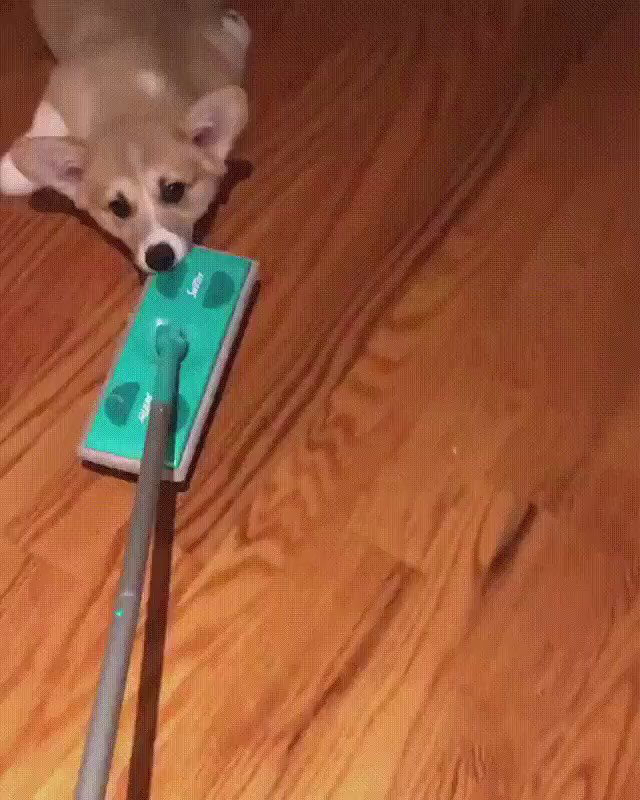

In [70]:
url = df.jpg_url[403]
r = requests.get(url)
Image.open(BytesIO(r.content))

### Time of day with most retweets

Text(0, 0.5, 'Number of Retweets')

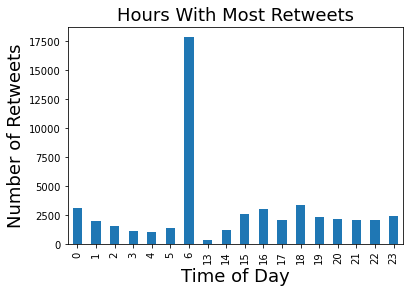

In [71]:
hours = df.groupby('hour').retweet_count.mean().plot(kind='bar')
plt.title('Hours With Most Retweets', fontsize = 18)
plt.xlabel('Time of Day', fontsize = 18)
plt.ylabel('Number of Retweets', fontsize = 18)

### Time of day with most favorite

In [72]:
df.query('prediction1_dog == True').prediction1.value_counts()[:20]

Golden Retriever             139
Labrador Retriever            92
Pembroke                      88
Chihuahua                     79
Pug                           55
Chow                          41
Samoyed                       39
Pomeranian                    38
Toy Poodle                    37
Malamute                      29
Cocker Spaniel                27
French Bulldog                25
Chesapeake Bay Retriever      23
Miniature Pinscher            22
German Shepherd               20
Siberian Husky                20
Maltese Dog                   18
Eskimo Dog                    18
Staffordshire Bullterrier     18
Shetland Sheepdog             18
Name: prediction1, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

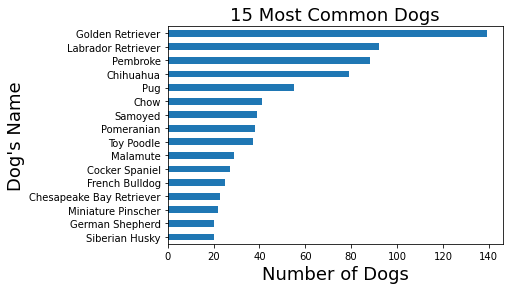

In [75]:
# plot the 15 most common dogs 
df.query('prediction1_dog == True').prediction1.value_counts()[15::-1].plot(kind = 'barh')
plt.title("15 Most Common Dogs", fontsize = 18)
plt.xlabel('Number of Dogs', fontsize = 18)
plt.ylabel("Dog's Name", fontsize = 18)
plt.show

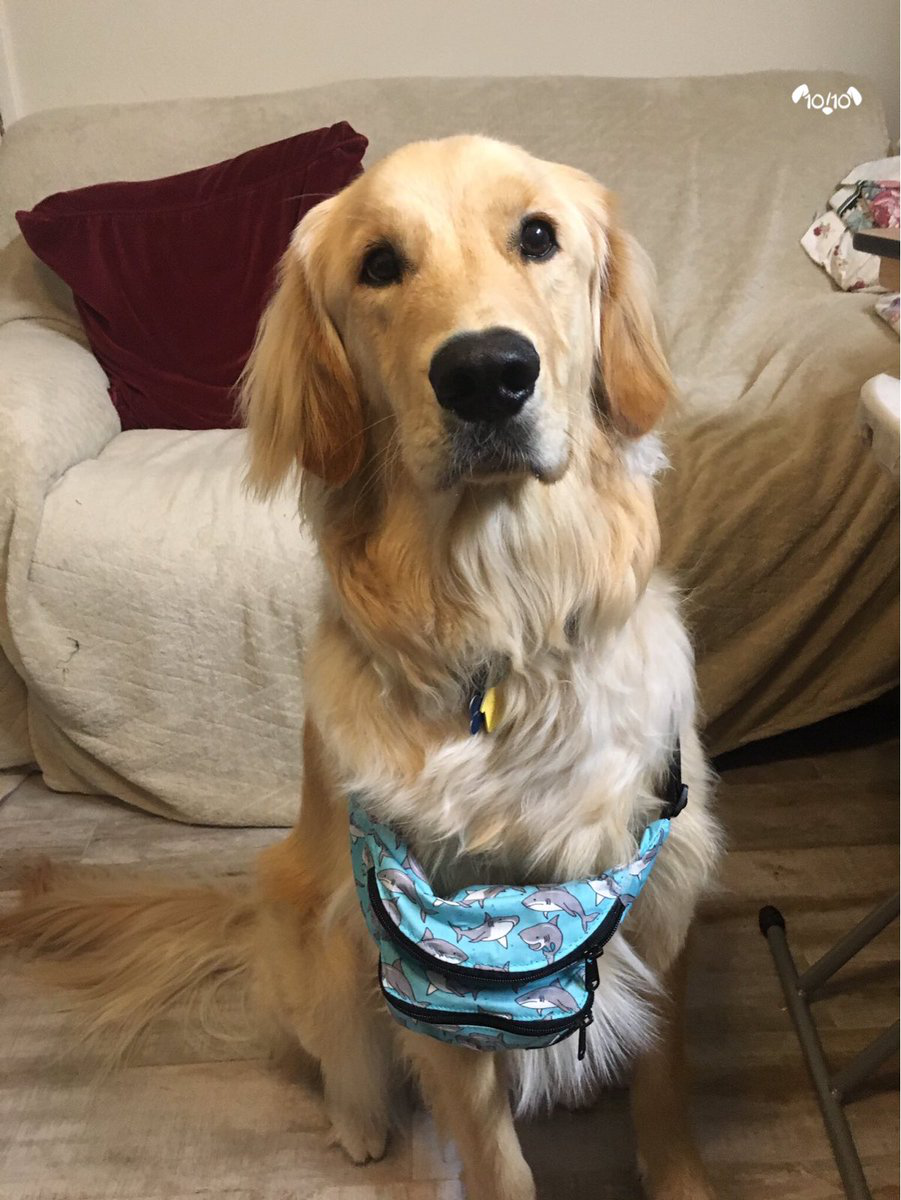

In [78]:
df[df['prediction1'] == 'Golden Retriever']
url = df.jpg_url[14]
r = requests.get(url)
Image.open(BytesIO(r.content))

### Comparison between dog ratings and retweet counts

<function matplotlib.pyplot.show(close=None, block=None)>

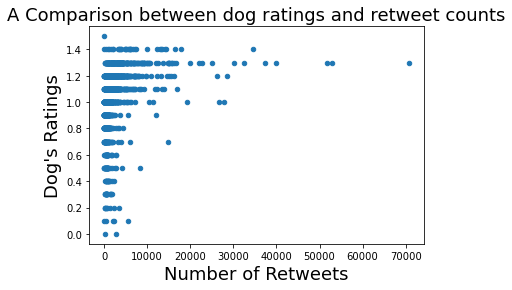

In [79]:
df.plot.scatter(x = 'retweet_count', y = 'dogs_ratings')
plt.title('A Comparison between dog ratings and retweet counts', fontsize = 18)
plt.xlabel('Number of Retweets', fontsize = 18)
plt.ylabel("Dog's Ratings", fontsize = 18)
plt.show

### Dogs rating relationship to dogs favorites

<function matplotlib.pyplot.show(close=None, block=None)>

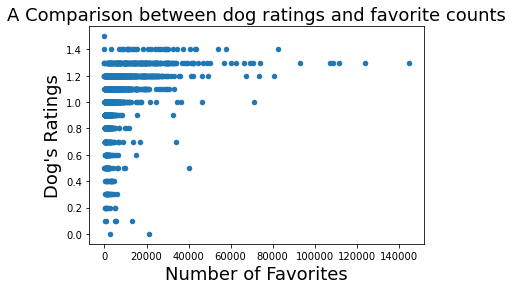

In [82]:
df.plot.scatter(x = 'favorite_count', y = 'dogs_ratings')
plt.title('A Comparison between dog ratings and favorite counts', fontsize = 18)
plt.xlabel('Number of Favorites', fontsize = 18)
plt.ylabel("Dog's Ratings", fontsize = 18)
plt.show

## Conclusion

1. Stephan is the most liked dog. The dog had 51643	retweets and 111627 people tagged it as a favorite
2. Dogs posted around 6:00 a.m. were most likely to recieve high retweets and favorites compared to dogs posted on any other      time of the day.
3. Golden Retriever, Labrador Retriever, Pembroke, Chihuahua, and Pug are the most common breeds of dogs. Golden Retriever        breed is the most common breed of dog though.
4. There is a positive correlation between a dog's rating and the number of retweets a dog get. I.e., the higher the rating of    a dog, the higher the number of retweets that particular dog is likely to receive. 
5. Similarly, there was a positive correlation between a dog's rating and the number of favorites.

## Limitations

1. There might have quality issues in the data that may not have been detected and/or corrected.
2. More types of analyses may be done be done on the data to get more insights